In [1]:
library(tidyverse)
library(rtracklayer)
library(ComplexHeatmap)
library(Seurat)


Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.5.1     v purrr   0.3.4
v tibble  3.2.1     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do

In [2]:
tissues = c("adrenal", "cortex", "hippocampus", "heart", "gastrocnemius")
level = "celltypes"
color_level = "celltype_color"

l2fc_cutoff <- 2
padj_cutoff <- 0.01


# Supp. fig 11a

In [3]:
options(scipen=999)
ccres = as.data.frame(read.table("../snatac/ref/ENCFF167FJQ.bed",
                                  header = FALSE, sep="\t",
                                  stringsAsFactors=FALSE, quote=""))
ccres$peakID <- paste0(ccres$V1, "_", ccres$V2, "_", ccres$V3)
ccres$index = paste0(ccres$V1, "_", ccres$V2+1, "_", ccres$V3)

ccres  = ccres[,c("V4","V10","index")]
colnames(ccres) = c("name","ccre_type","index")

In [4]:
head(ccres)

,name,ccre_type,index
,<chr>,<chr>,<chr>
1,EM10E0932225,CA-CTCF,chr1_3012682_3012836
2,EM10E1235196,CA,chr1_3035822_3035995
3,EM10E1235197,CA,chr1_3059628_3059790
4,EM10E1235198,CA,chr1_3062548_3062749
5,EM10E1235199,CA,chr1_3062790_3063138
6,EM10E1235200,CA,chr1_3094795_3095138


In [5]:
accessible_ccres_list = readRDS("data/fig4_all_tissues_all_ccre_pie_slice_cluster_method_final_celltypes.rds")


In [6]:
accessible_ccres = ccres[ccres$index %in% accessible_ccres_list, ]
dim(accessible_ccres)

[1] 390146      3

In [7]:
# Calculate the total number of accessible cCREs per type
accessible_ccres_per_type <- accessible_ccres %>%
  group_by(ccre_type) %>%
  summarise(accessible = n())

# Calculate the total number of accessible cCREs
total_accessible_ccres <- sum(accessible_ccres_per_type$accessible)

# Calculate the percentage of accessible cCREs per type out of the total accessible cCREs
accessible_ccres_per_type <- accessible_ccres_per_type %>%
  mutate(percentage = (accessible / total_accessible_ccres) * 100)

accessible_ccres_per_type <- accessible_ccres_per_type[order(-accessible_ccres_per_type$percentage),]
accessible_ccres_per_type$ccre_type = factor(accessible_ccres_per_type$ccre_type, levels =accessible_ccres_per_type$ccre_type)



In [8]:
color_palette <- c(
  "dELS" = "#f5c811",
  "pELS" = "#f59a13",
  "PLS" = "#f51113",
  "TF" = "#56d59b",
  "CA" = "#6fa189",
  "CA-CTCF" = "#eea4a0",
  "CA-H3K4me3" = "#af88d9",
  "CA-TF" = "#42b6f4"
)


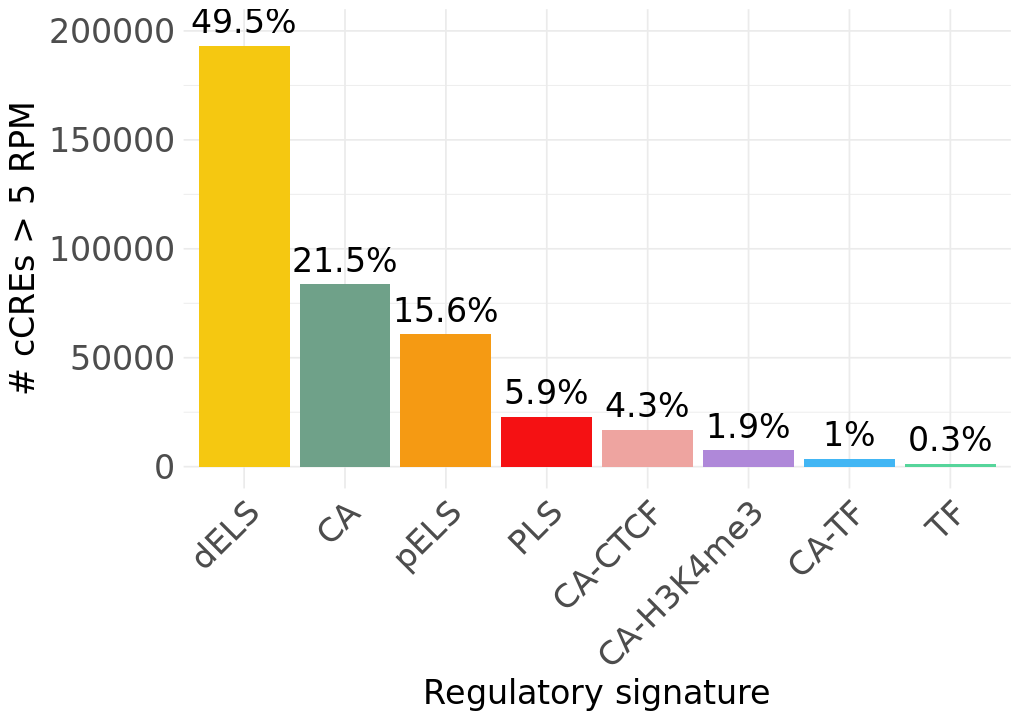

In [17]:
options(repr.plot.width = 8.5, repr.plot.height = 6)

ggplot(accessible_ccres_per_type, 
       aes(x = ccre_type, y = accessible, fill = ccre_type)) +
  ylim(0,200000) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = paste0(round(percentage, 1), "%"), y = accessible + 0.5), 
            position = position_dodge(0.9), vjust = -0.5, size = 7) +
  labs(x = "Regulatory signature",
       y = "# cCREs > 5 RPM")+ scale_fill_manual(values = color_palette) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 20, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 20),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    legend.position = "none"
  )


# Supp. fig 11b

In [ ]:
accessible_ccres$start = as.numeric(do.call("rbind", strsplit(accessible_ccres$index, "_"))[,2])
accessible_ccres$stop = as.numeric (do.call("rbind", strsplit(accessible_ccres$index, "_"))[,3])


In [ ]:
accessible_ccres$width = accessible_ccres$stop - accessible_ccres$start

In [ ]:
median(accessible_ccres$width)

[1] 306

Warning message:
"`position_dodge()` requires non-overlapping x intervals."


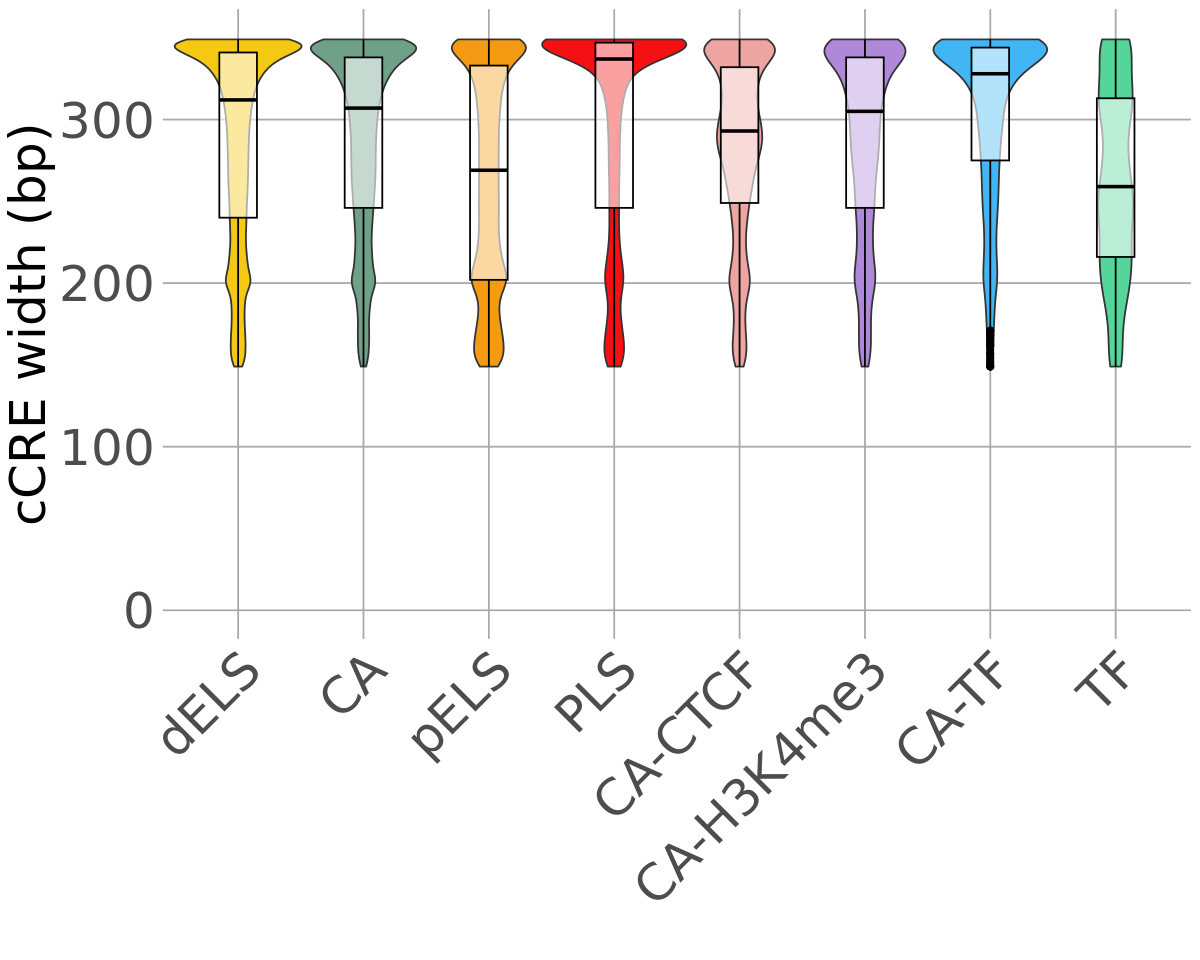

In [21]:
options(repr.plot.width = 10, repr.plot.height = 8)

accessible_ccres$ccre_type = factor(accessible_ccres$ccre_type, levels = c("dELS", "CA", "pELS",
                                                                          "PLS", "CA-CTCF", "CA-H3K4me3", 
                                                                           "CA-TF", "TF"))

ggplot(accessible_ccres, aes(x = ccre_type, y = width, fill = ccre_type)) +
  geom_violin(width = 1.15) +
  geom_boxplot(width = 0.3, fill = "white", color = "black", alpha = 0.6) +
  scale_fill_manual(values = color_palette) + 
  labs(x = "",
       y = "cCRE width (bp)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, 
                                   hjust = 1, size = 30 ), 
        axis.text.y = element_text(size = 30), 
        axis.title.x = element_text(size = 20),
        title = element_text(size = 30), 
        legend.position = "none",
        panel.grid.major = element_line(color = "darkgrey", linewidth = 0.5), 
        panel.grid.minor = element_blank()) + ylim(0,350)